### Use Log Exploration / Unsupervised Learning

In [2]:
import numpy as np
import pandas as pd

import data_manipulation as dm
import time
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
#memb = dm.members()
#txn= dm.transactions()
train = dm.train()
#ul = dm.user_logs()

In [3]:
"""
ul[ul['total_secs']<0].head()
ul['total_secs'].describe()
ul['num_25'].describe()
ul['num_50'].describe()
ul['num_75'].describe()
ul['num_985'].describe()
ul['num_100'].describe()
ul['num_unq'].describe()

print ('total nulls for total_secs: %s' %(len(ul[pd.isnull(ul['total_secs'])==True])))
print ('total nulls for num_25: %s' %(len(ul[pd.isnull(ul['num_25'])==True])))
print ('total nulls for num_50: %s' %(len(ul[pd.isnull(ul['num_50'])==True])))
print ('total nulls for num_75: %s' %(len(ul[pd.isnull(ul['num_75'])==True])))
print ('total nulls for num_985: %s' %(len(ul[pd.isnull(ul['num_985'])==True])))
print ('total nulls for num_100: %s' %(len(ul[pd.isnull(ul['num_100'])==True])))
print ('total nulls for num_unq: %s' %(len(ul[pd.isnull(ul['num_unq'])==True])))

ul['total_secs'].quantile(0.985)

ul['secs_capped'] = ul['total_secs'].clip(lower = 0, upper = ul['total_secs'].quantile(0.985))
ul['secs_capped'].describe()
sns.boxplot(ul['secs_capped'], color='green')
""";

## Working with pivoted data - Monthly Median Seconds

In [51]:
tmonths = pd.read_csv('../ul_tsecs_month_median.csv', index_col = 'new_id')
tmonths.head()

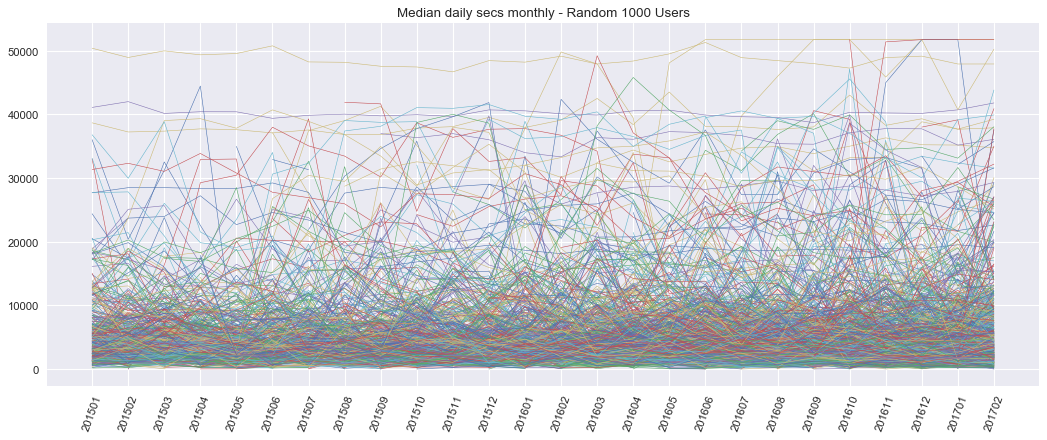

In [53]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

user_count = 1000

for i in range(user_count):
    x = tmonths.loc[np.random.choice(tmonths.index, 1), :].values.reshape(26,1)
    plt.plot(x, lw=0.5)

plt.xticks(range(26),tmonths.columns.values, rotation=70)
plt.title('Median daily secs monthly - Random {} Users'.format(user_count));

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


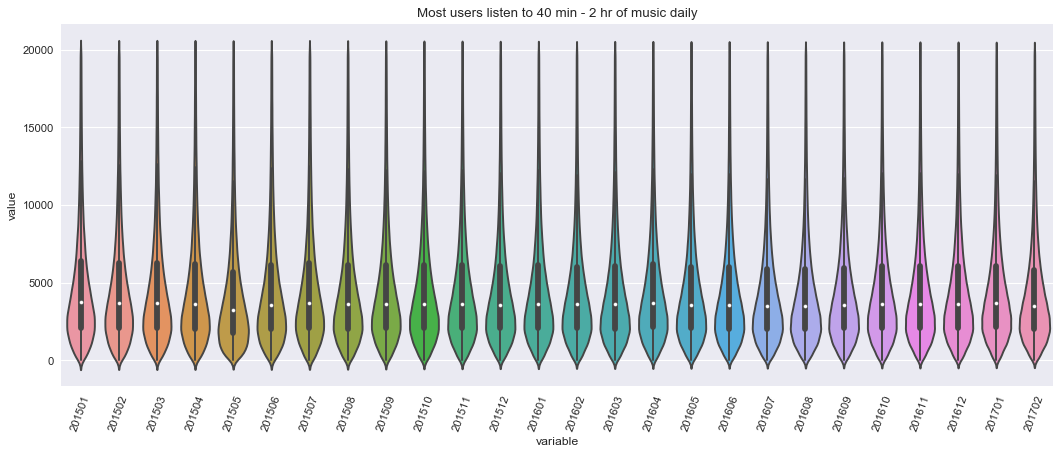

In [54]:
tmonths_melted = pd.melt(tmonths)
tmonths_melted = tmonths_melted[tmonths_melted['value'] < 20000]
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.violinplot(tmonths_melted['variable'], tmonths_melted['value'])
plt.xticks(range(26),tmonths.columns.values, rotation=70);
plt.title('Most users listen to 40 min - 2 hr of music daily')

In [55]:
## Normalize data?
#tmonths_masked = np.ma.array(tmonths, mask=np.isnan(tmonths))
#x_norm = np.linalg.norm(tmonths_masked, axis = 1, keepdims = True)

## Working with pivoted data - Monthly Sum Seconds

In [190]:
sum_months = pd.read_csv('../ul_tsecs_month.csv', index_col='new_id')
sum_months.head(2)

,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,...,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702
new_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,148668.078125,256812.000000,157868.671875,156533.953125
1,22478.4375,48230.347656,21394.044922,46322.765625,30584.423828,11007.208008,16073.696289,13551.139648,354358.8125,358967.375,...,299499.71875,145388.6875,120546.710938,185178.171875,173410.828125,190726.328125,133337.859375,154978.390625,198105.281250,189007.843750


/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


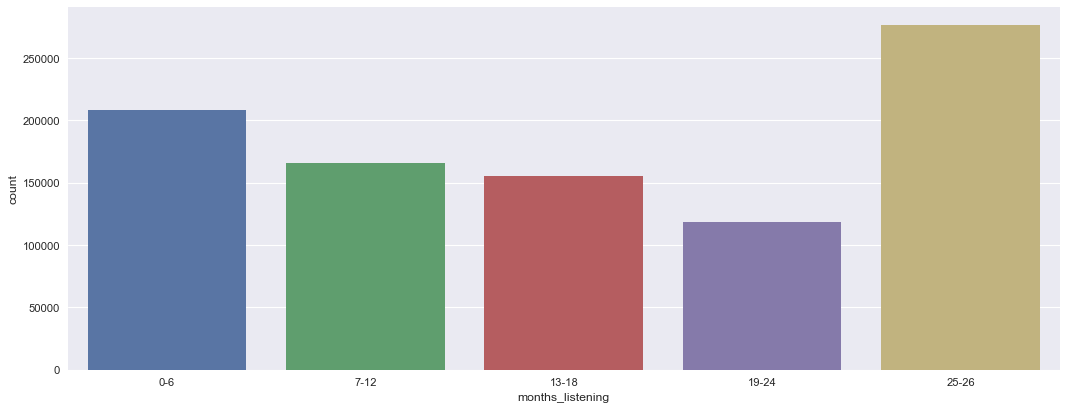

In [191]:
## add a column to calculate months of user_log data (not necessarily consecutive and removing Feb)
sum_months['p26'] = np.count_nonzero(sum_months.fillna(0).drop('201702',axis=1), axis = 1)

sum_months['months_listening'] = pd.cut(sum_months['p26'], [0,6,12,18,24,30], labels=['0-6','7-12','13-18','19-24','25-26'])
#print (sum_months['non_null'].head())

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.countplot(sum_months['months_listening']);

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


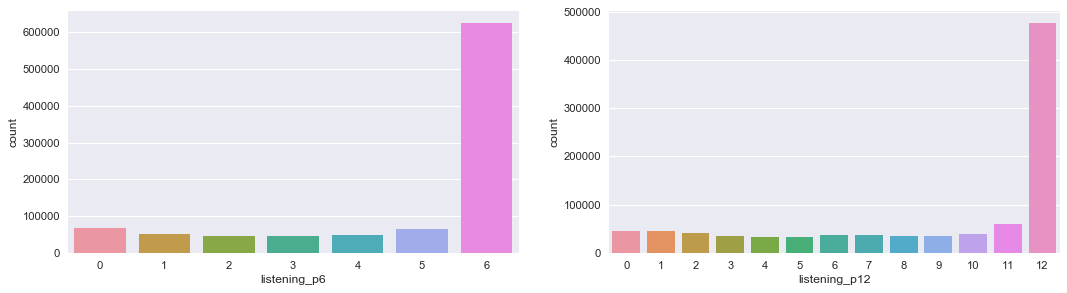

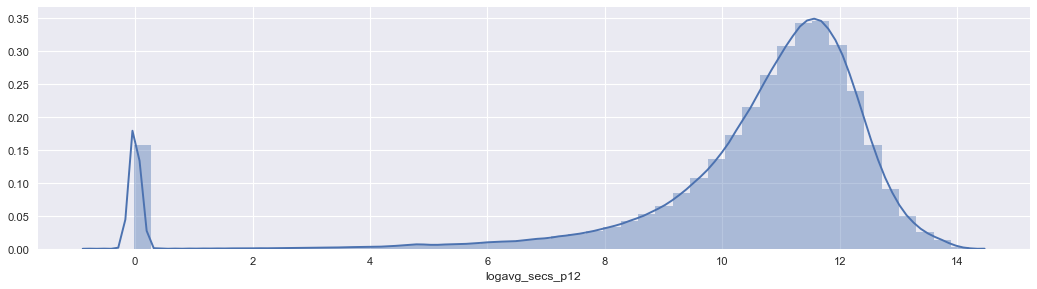

In [193]:
### calculate months with song data in past 6 and 12 months
### bear in mind we are skipping February as it is the expiration month and we know some let it expire

p6 = ['201701','201612','201611','201610','201609','201608']
p12 = ['201701','201612','201611','201610','201609','201608','201607','201606','201605','201604','201603','201602']

sum_months['listening_p6'] = np.count_nonzero(sum_months[p6].fillna(0), axis = 1)
sum_months['listening_p12'] = np.count_nonzero(sum_months[p12].fillna(0), axis = 1)
sum_months['logavg_secs_p12'] = np.log((np.sum(sum_months[p12].fillna(0), axis = 1)+1)/(sum_months['listening_p12']+1))

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.countplot(sum_months['listening_p6'])
plt.subplot(1,2,2)
sns.countplot(sum_months['listening_p12'])

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(sum_months['logavg_secs_p12'])

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


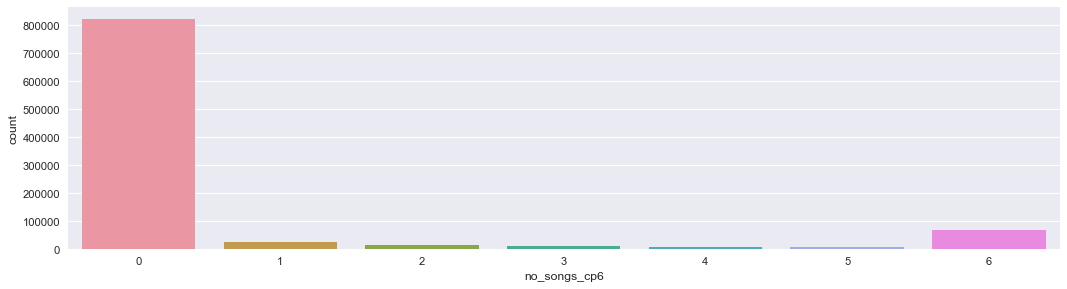

In [194]:
### calculate descending consecutive months with no log data (no songs consecutive previous 6 months, or no_songs_cp6)
### Again, skipping February as it is the month of expiration

no_songs = []
for id in np.unique(sum_months.index.values):
    total_months = 0
    if np.isnan(sum_months.loc[id, '201701']):
        total_months += 1
        if np.isnan(sum_months.loc[id, '201612']):
            total_months += 1
            if np.isnan(sum_months.loc[id, '201611']):
                total_months += 1
                if np.isnan(sum_months.loc[id, '201610']):
                    total_months += 1
                    if np.isnan(sum_months.loc[id, '201609']):
                        total_months += 1
                        if np.isnan(sum_months.loc[id, '201608']):
                            total_months += 1
    no_songs.append(total_months)

sum_months['no_songs_cp6'] = no_songs

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.countplot(sum_months['no_songs_cp6'])

<i>Only few people had from 1-6 consecutive months without listening data. Interesting to see how they relate to churn and what kind of subscribers they are (monthly, yearly). Those two pieces in combination could be very valuable </i>

In [195]:
sum_months.head(2)

,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,...,201611,201612,201701,201702,p26,months_listening,listening_p6,listening_p12,logavg_secs_p12,no_songs_cp6
new_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,148668.078125,256812.000000,157868.671875,156533.953125,3,0-6,3,3,11.855362,0
1,22478.4375,48230.347656,21394.044922,46322.765625,30584.423828,11007.208008,16073.696289,13551.139648,354358.8125,358967.375,...,133337.859375,154978.390625,198105.281250,189007.843750,25,25-26,6,12,12.009256,0


In [196]:
x =  train.merge(sum_months.reset_index(), left_on='new_id', right_on='new_id', how='inner', copy = False)[
    ['new_id','is_churn','no_songs_cp6','p26','months_listening','listening_p6','listening_p12','logavg_secs_p12']]

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


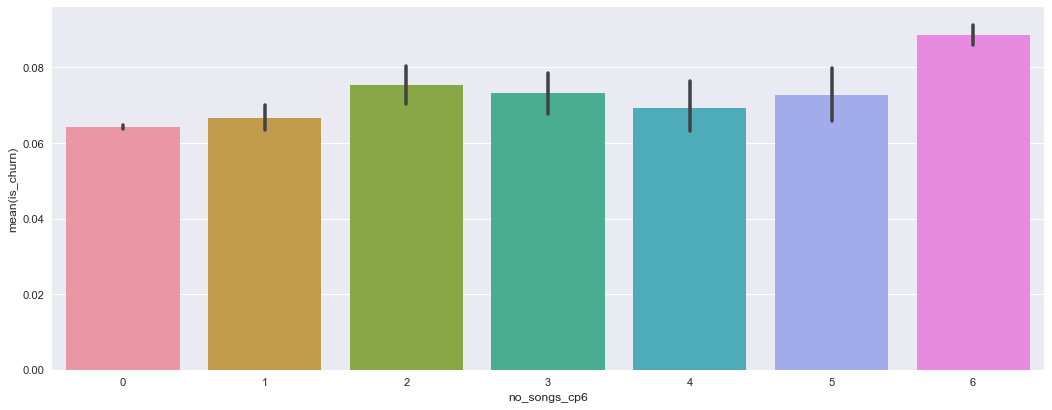

In [197]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('no_songs_cp6', 'is_churn', data=x);

<i>There seem to be an upward trend in churn based on the consecutive months without listening data. It is not clear why the wave from 3-5 months without listening data. Are those filled with dormant users?</i>

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


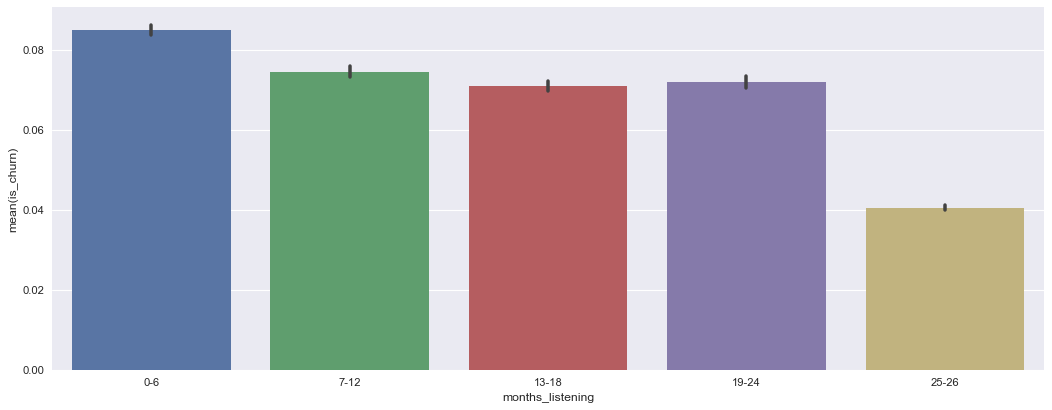

In [198]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('months_listening', 'is_churn', data=x);

<i>It seems that users with 0-6 months of listening data are more likely to churn than long-term users</i>

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


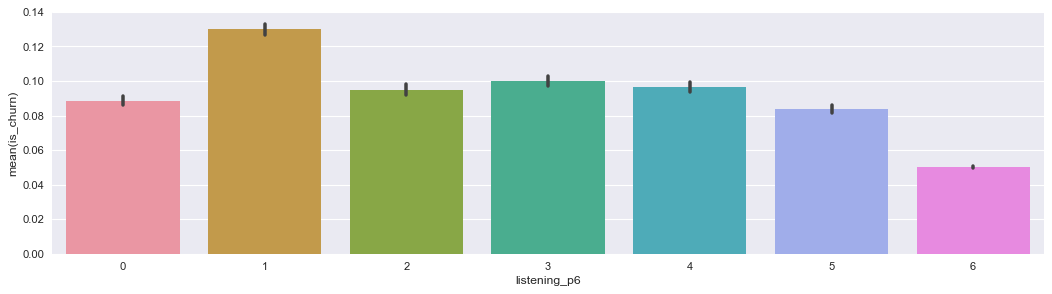

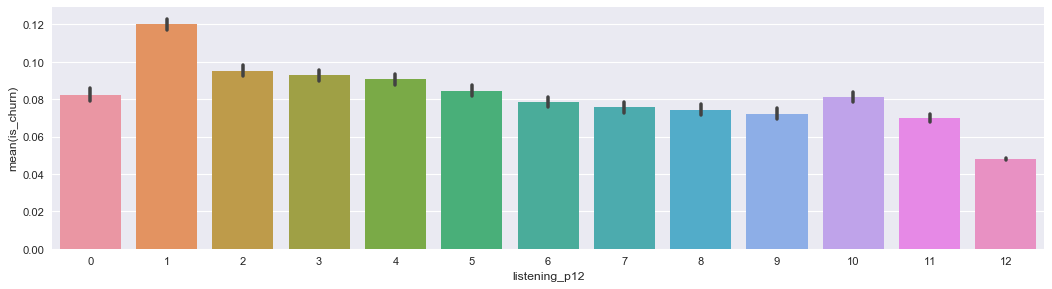

In [199]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('listening_p6', 'is_churn', data=x);

plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('listening_p12', 'is_churn', data=x);

<i>Again, Users with less listening months seem to be more likely to churn</i>

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:885: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:905: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


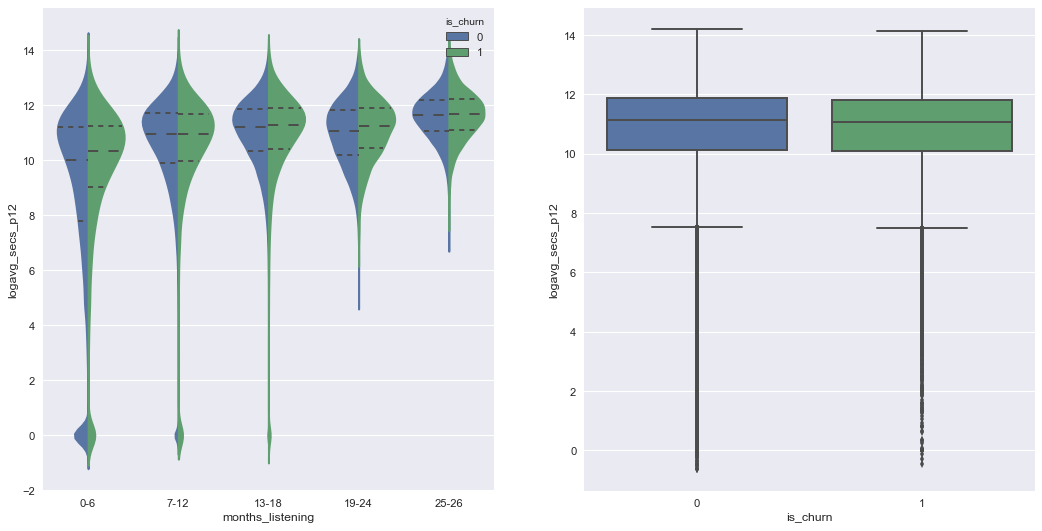

In [200]:
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.violinplot( x['months_listening'] , x['logavg_secs_p12'], hue =x['is_churn'] , split=True, inner="quartile");

plt.subplot(1,2,2)
sns.boxplot(  x['is_churn'] , x['logavg_secs_p12']);

<i>Total seconds does not show any clear relationship with churn </i>

### Useful Variables:

<table>
<th>months listening</th>
<th>listening_p12</th>
<th>no_songs_cp6</th>
<th>logavg_secs_p12</th>
<tr>
    <td>categorical[5]</td>
    <td>discrete[0-12]</td>
    <td>discrete[0-6]</td>
    <td>continuous</td>
</tr>
</table>

## Working with pivoted data - Monthly Unique Songs + Monthly Total Songs

In [208]:
munique_sum = pd.read_csv('../num_unq_sum.csv', index_col = 'new_id')
munique_median = pd.read_csv('../num_unq_median.csv', index_col = 'new_id')

msongs_sum = pd.read_csv('../ul_tsongs_month.csv', index_col = 'new_id')
msongs_median = pd.read_csv('../ul_tsongs_month_median.csv', index_col = 'new_id')

msecs_sum = pd.read_csv('../ul_tsecs_month.csv', index_col = 'new_id')
msecs_median = pd.read_csv('../ul_tsecs_month_median.csv', index_col = 'new_id')

In [228]:
#create index of unique songs / total number of songs
variety_songs = np.divide(munique_median, msongs_median)
variety_secs = np.divide(msecs_median, munique_median)

In [229]:
variety_songs.head(2)

,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,...,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702
new_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.695088,0.769329,0.971777,0.932118
1,1.0,1.169231,1.0,0.571429,0.969697,1.0,1.006036,1.090909,0.712691,1.000406,...,0.83294,0.984615,1.020809,1.000341,0.896763,1.13852,1.001252,1.085850,0.960000,0.762631


In [230]:
variety_secs.head(2)

,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,...,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702
new_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,315.291439,294.958822,222.049161,251.205864
1,273.172803,169.072895,232.164836,394.818359,212.904633,173.194661,222.780005,214.625,328.484505,242.600269,...,282.866432,239.985306,226.7577,236.508256,274.617045,208.874734,239.535177,212.858307,235.248454,291.907091


/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


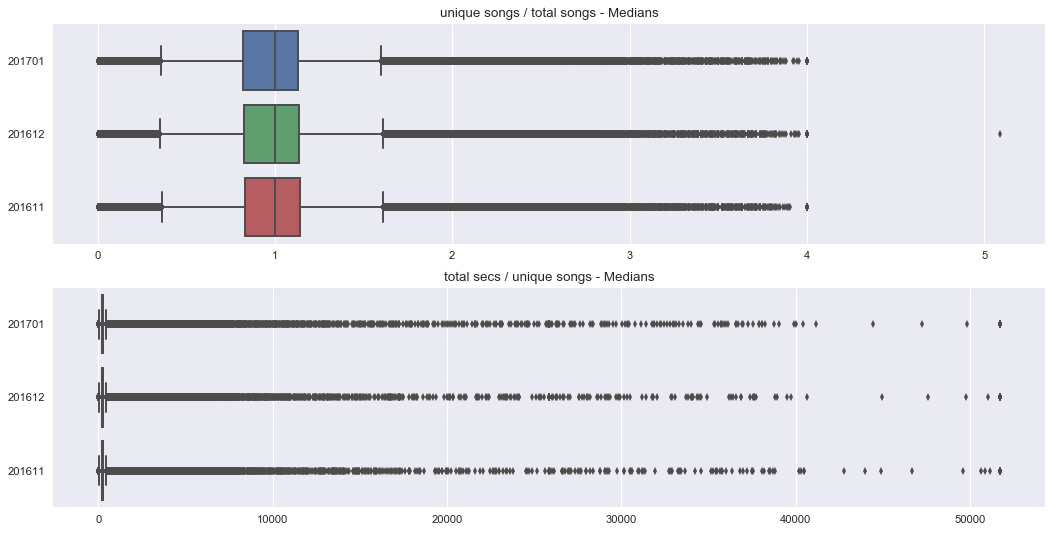

In [231]:
plt.figure(num=None, figsize=(16,8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.title('unique songs / total songs - Medians');
sns.boxplot(variety_songs[['201701','201612','201611']], orient='h')

plt.subplot(2,1,2)
plt.title('total secs / unique songs - Medians');
sns.boxplot(variety_secs[['201701','201612','201611']], orient='h')

<span style="color:blue"> <i>
it is important to notice the number of unique songs could be for incomplete unique songs. Therefore number of total songs might be lower than the number of unique songs. The idea of a number of "total songs" is the equivalent of total songs given the average [median] length of a song. Therefore it might make more sense to use total_secs. </i></span>

## Test some clusters on median seconds monthly

<span style="color:blue"> <i> 
The benefit of using median is it only counts days with activity. However, if fails to capture intensity of listening behavior, which is better captured with the <strong>sum</strong>. Essentially we need both, and we need to evaluate a way to caputure the change in behavior daily/monthly.
</i></span>

In [252]:
##In order to test some clusters need to replace NAs, with 0 in this case.
tmonths = pd.read_csv('../ul_tsecs_month_median.csv', index_col="new_id")
tmonths.fillna(0, inplace = True)

Clusters: 3


/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


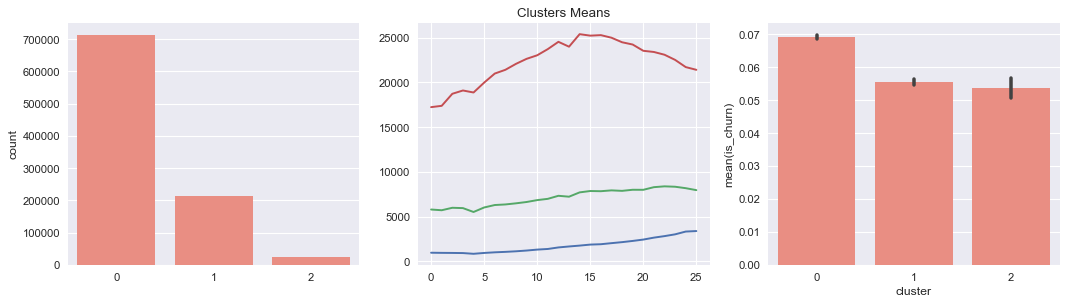

Clusters: 4


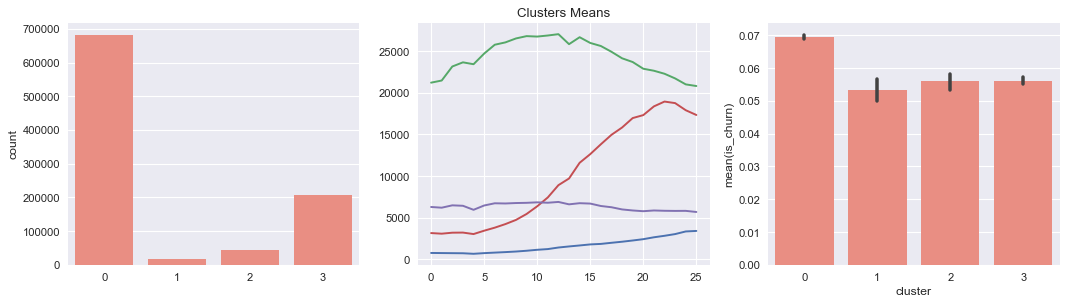

Clusters: 5


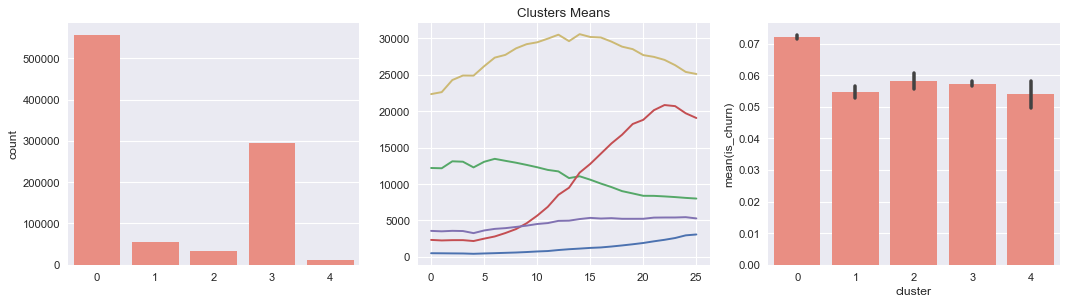

Clusters: 6


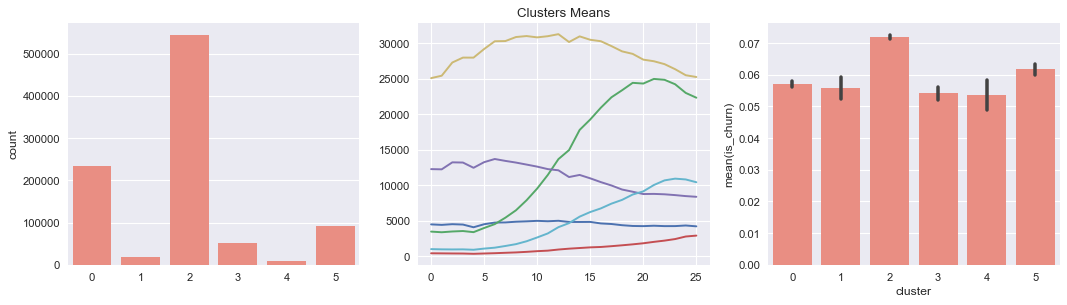

Clusters: 7


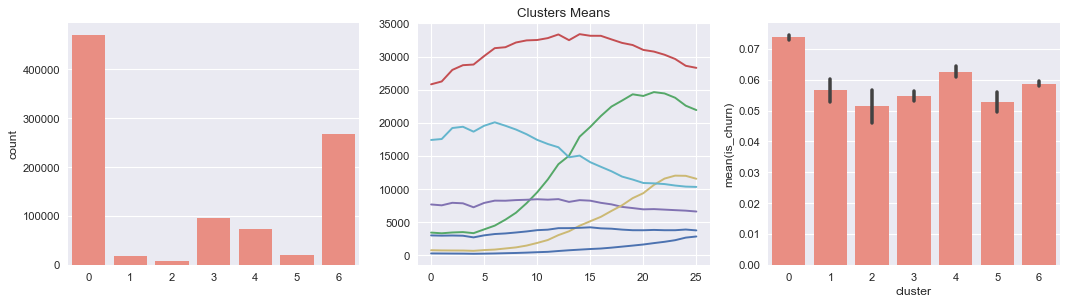

Clusters: 8


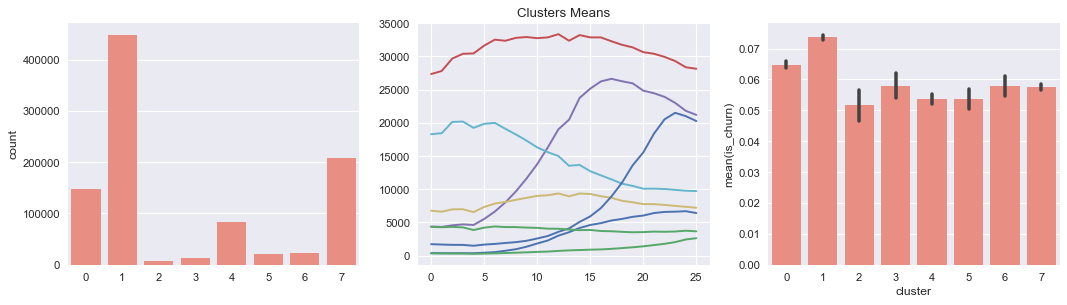

Clusters: 9


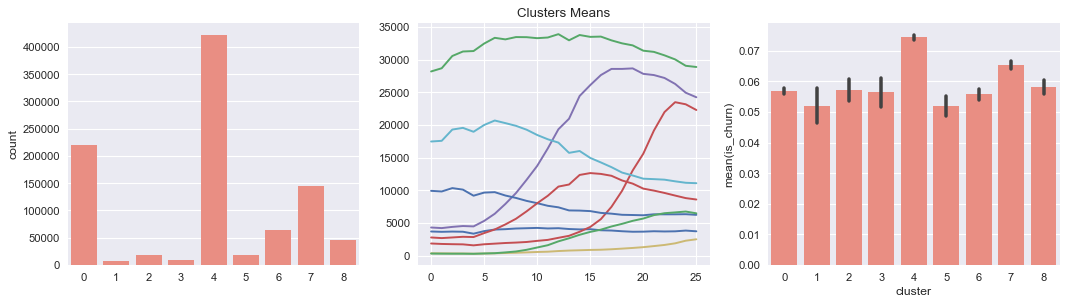

In [253]:
from sklearn.cluster import KMeans
sclusters = [3,4,5,6,7,8,9]
tmonths_temp = tmonths.copy(deep=True)

for scluster in sclusters:
    kmeans = KMeans(n_clusters=scluster, random_state=0).fit(tmonths)
    tmonths_temp['cluster'] = kmeans.labels_
    x_temp =  train.merge(tmonths_temp.reset_index(), left_on='new_id', right_on='new_id', how='inner', copy = False)[
    ['new_id','is_churn','cluster']]
    
    plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
    print ('Clusters: {}'.format(scluster))
    plt.subplot(1,3,1)
    sns.countplot(kmeans.labels_, color="salmon")

    plt.subplot(1,3,2)
    plt.title('Clusters Means')
    plt.plot(kmeans.cluster_centers_.T);
    
    plt.subplot(1,3,3)
    sns.barplot(x_temp['cluster'], x_temp['is_churn'], color="salmon")
    plt.show()

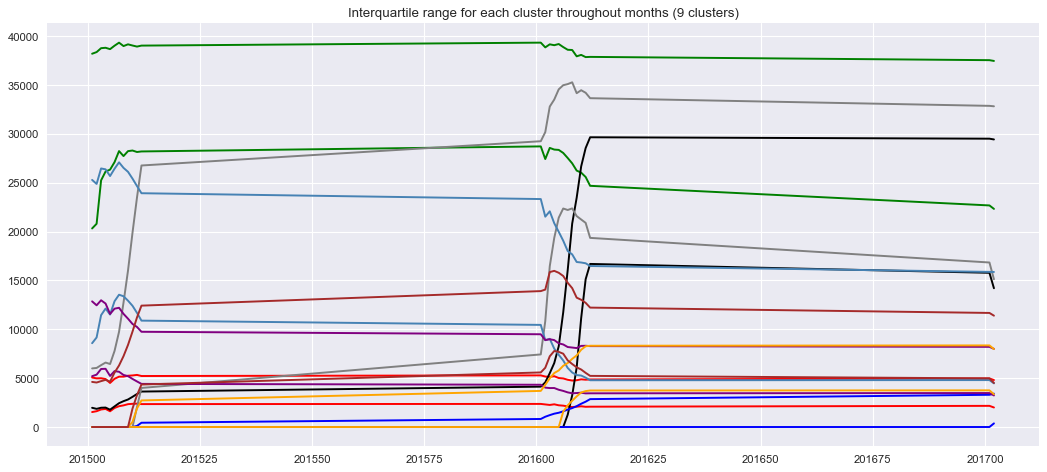

In [234]:
tmonths_c9 = tmonths
tmonths_c9['cluster'] = kmeans.labels_

colors = ['red','green','black','grey', 'blue', 'steelblue', 'purple', 'orange', 'brown']
counter = 0
plt.figure(num=None, figsize=(16, 7), dpi=80, facecolor='w', edgecolor='k')
for cluster in np.unique(kmeans.labels_):
    plt.plot(tmonths_c9[tmonths_c9['cluster'] == cluster].drop('cluster', axis = 1).quantile(0.25), color = colors[counter]);
    plt.plot(tmonths_c9[tmonths_c9['cluster'] == cluster].drop('cluster', axis = 1).quantile(0.75), color = colors[counter]);
    counter += 1
    
plt.title('Interquartile range for each cluster throughout months ({0} clusters)'.format(counter))
plt.show()

##very hard to see, but very informative chart. Lots of overlaps and massive distances in the interquartile ranges.
##this <might> point to poorly separated clusters. Perhaps graph with heatmap

In [251]:
##try hierarchical clustering here(watch out on computing power needed)